<a href="https://colab.research.google.com/github/british2002/Deep-Learning/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD%D1%8B_%D0%B0%D0%BA%D1%86%D0%B8%D0%B8_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Установка

In [ ]:
#установим пакет Мосбиржи
!pip install moexalgo

In [ ]:
#установим пакет Darts
!pip install darts

In [ ]:
!pip install "u8darts[all]"

# 0.1. Подготовка данных

In [ ]:
#импортируем библиотеки и методы для работы
import numpy as np
import pandas as pd
import os

from moexalgo import Ticker, Market
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import darts
from darts import TimeSeries
from darts.metrics import mae, rmse, mape, smape, r2_score



import warnings
warnings.filterwarnings('ignore')

from darts.models import NaiveMean
from darts.models import AutoARIMA
from darts.models import ExponentialSmoothing
from darts.models import CatBoostModel

In [ ]:
#для информации загрузим список акций Мосбиржи
stocks = Market("shares")
all_stocks = pd.DataFrame(stocks.tickers())
all_stocks

,ticker,shortname,lotsize,decimals,minstep,issuesize,isin,regnumber,listlevel
0,ABIO,iАРТГЕН ао,10,2,0.020,92645451,RU000A0JNAB6,1-01-08902-A,2
1,ABRD,АбрауДюрсо,10,1,0.200,98000184,RU000A0JS5T7,1-02-12500-A,3
2,AFKS,Система ао,100,3,0.001,9650000000,RU000A0DQZE3,1-05-01669-A,1
3,AFLT,Аэрофлот,10,2,0.010,3975771215,RU0009062285,1-01-00010-A,1
4,AKRN,Акрон,1,0,2.000,36757156,RU0009028674,1-03-00207-A,2
...,...,...,...,...,...,...,...,...,...
253,YRSB,ТНСэнЯр,10,0,2.000,17143584,RU000A0D8760,1-01-50099-A,3
254,YRSBP,ТНСэнЯр-п,10,1,0.500,4507320,RU000A0D88B3,2-01-50099-A,3
255,ZAYM,Займер ао,10,2,0.050,100000000,RU000A107RM8,1-01-16767-A,3
256,ZILL,ЗИЛ ао,1,0,5.000,2659962,RU0009086193,1-02-00036-A,3


In [ ]:
def load_stock_data(stock_symbol, start_date, end_date):
    # код для загрузки котировок по заданным параметрам
    # Возвращаем DataFrame

    df = Ticker(stock_symbol).candles(start=start_date, end=end_date, period='1d')
    print(stock_symbol,
          ' - Загружаем с', start_date.strftime('%Y-%m-%d'), 'по', end_date.strftime('%Y-%m-%d'),
          ". Загружено с", df['begin'].min().strftime('%Y-%m-%d'), 'по', df['begin'].max().strftime('%Y-%m-%d'), '.')
    return df


In [ ]:
def update_stock_data(stock_symbol):
    # Определяем имя файла для акции
    filename = f"{stock_symbol}.csv"
    old_filename = f"/kaggle/input/moexalgo-data/{filename}"
    # old_filename = filename

    # Проверяем наличие файла
    if os.path.exists(old_filename):
        try:
            # Загружаем ранее сохраненные данные
            stock_data = pd.read_csv(old_filename)

            # Определяем последнюю загруженную дату
            last_date = pd.to_datetime(stock_data['begin'].max())

            # Если last_date в текущем дне, прекращаем выполнение функции
            if last_date.date() == datetime.now().date():
                shutil.copy(old_filename, filename)
                return

            # Загружаем новые данные начиная с последней даты
            new_data = load_stock_data(stock_symbol, last_date, datetime.now())

            # Фильтруем существующие данные по дате
            existing_data_filtered = stock_data[pd.to_datetime(stock_data['begin']) < new_data['begin'].min()]

            # Обновляем существующие данные
            stock_data = pd.concat([existing_data_filtered, new_data], ignore_index=True)
        except Exception as e:
            stock_data = load_stock_data(stock_symbol, datetime(2000, 1, 1), datetime.now())

    else:
        # Если файл не существует, загружаем все данные
        stock_data = load_stock_data(stock_symbol, datetime(2000, 1, 1), datetime.now())

    # Сохраняем данные на диск
    stock_data.to_csv(filename, index=False)

# Пример использования
# stock_symbol = 'AFKS'  # Замените на символ интересующей вас акции
# update_stock_data(stock_symbol)

In [ ]:
#нас интересуют акции АО Газпром
stock_symbol = 'GAZP'
update_stock_data(stock_symbol)

GAZP  - Загружаем с 2000-01-01 по 2025-08-24 . Загружено с 2014-06-09 по 2025-08-24 .


# 0.2. Компановка

In [ ]:
filename = stock_symbol+'.csv'
df = pd.read_csv(filename, parse_dates=True)
df.head(10)

,open,close,high,low,value,volume,begin,end
0,144.00,144.40,146.20,143.03,5.851239e+09,40347300.0,2014-06-09,2014-06-09 23:59:59
1,144.31,144.75,144.76,142.67,5.956067e+09,41460990.0,2014-06-10,2014-06-10 23:59:59
2,145.20,146.40,146.40,143.90,5.725373e+09,39418520.0,2014-06-11,2014-06-11 23:59:59
3,144.00,145.20,145.27,142.58,1.113453e+10,77165360.0,2014-06-16,2014-06-16 23:59:59
4,145.30,144.77,146.37,143.72,6.436430e+09,44370530.0,2014-06-17,2014-06-17 23:59:59
5,144.79,145.00,146.19,144.43,4.832640e+09,33270240.0,2014-06-18,2014-06-18 23:59:59
6,146.40,145.20,147.69,145.04,6.552395e+09,44670940.0,2014-06-19,2014-06-19 23:59:59
7,145.05,145.60,145.88,144.28,4.907721e+09,33779020.0,2014-06-20,2014-06-20 23:59:59
8,146.20,147.17,147.27,145.07,4.963199e+09,33923270.0,2014-06-23,2014-06-23 23:59:59
9,147.65,153.25,153.42,147.56,1.320014e+10,87546740.0,2014-06-24,2014-06-24 23:59:59


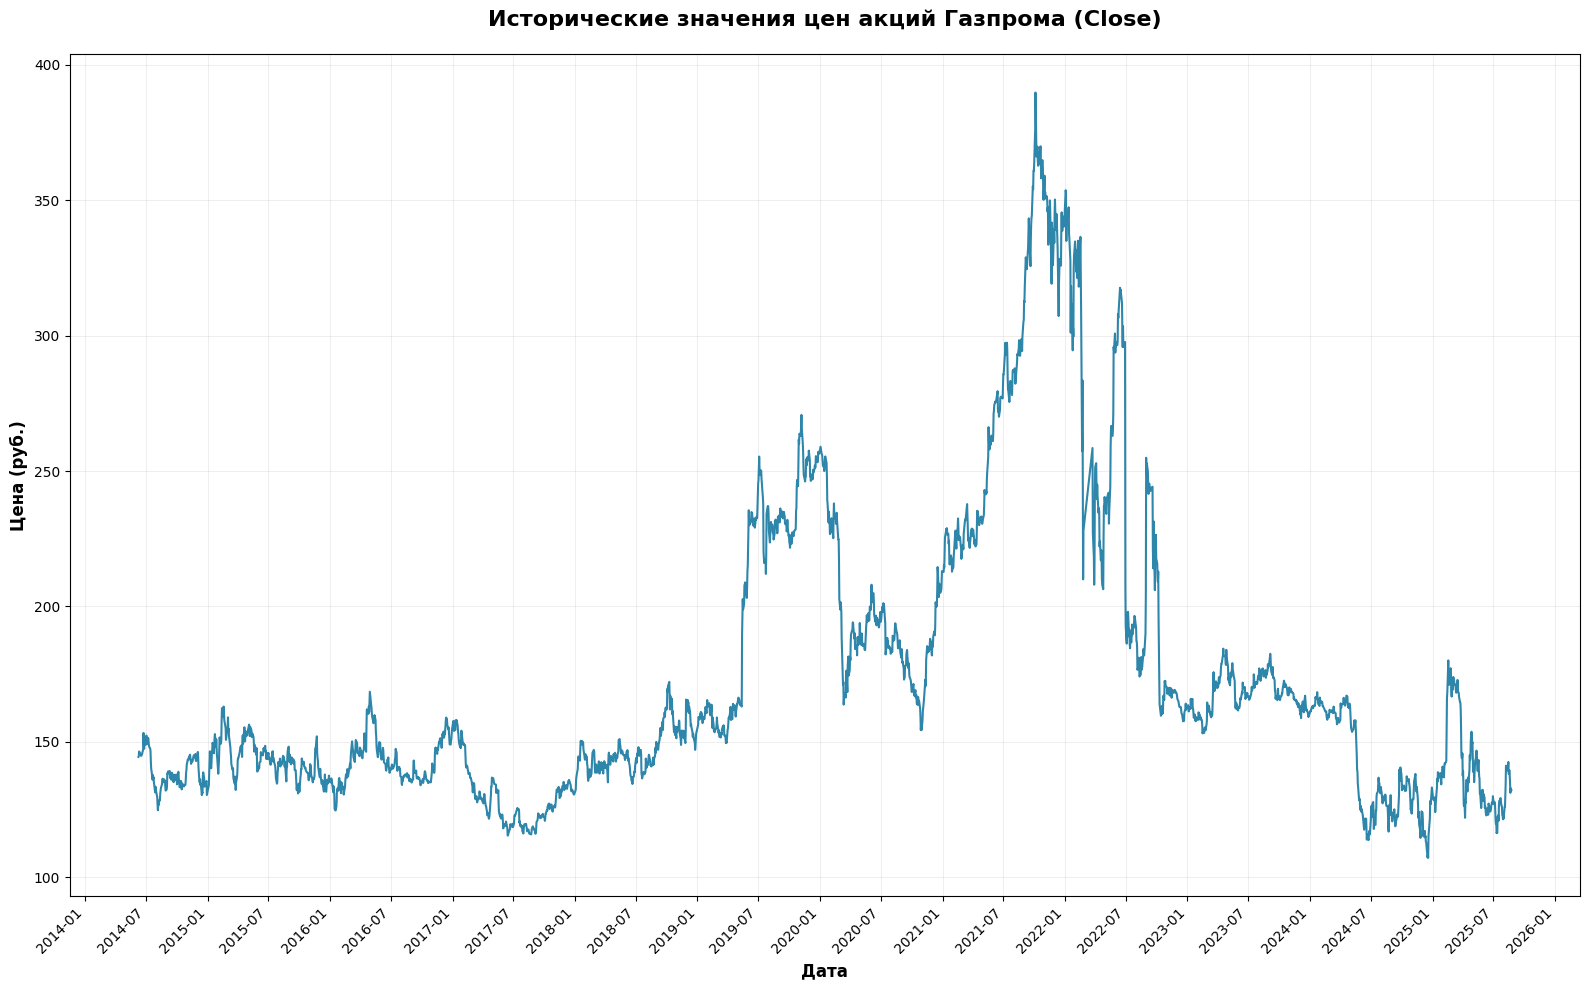

In [ ]:
# Конвертируем даты
df['begin'] = pd.to_datetime(df['begin'])

# Используем только столбец 'close' (цена закрытия)
close_prices = df['close'].values
dates = df['begin'].values

# Создаем фигуру с большим размером
plt.figure(figsize=(16, 10))

# Устанавливаем белый фон
plt.style.use('default')
ax = plt.gca()
ax.set_facecolor('white')
plt.gcf().set_facecolor('white')

# Строим график
plt.plot(dates, close_prices, linewidth=1.5, color='#2E86AB')

# Настраиваем заголовок и подписи осей
plt.title('Исторические значения цен акций Газпрома (Close)',
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=12, fontweight='bold')
plt.ylabel('Цена (руб.)', fontsize=12, fontweight='bold')

# Добавляем сетку
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Настраиваем форматирование дат на оси X
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Поворачиваем подписи дат для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Настраиваем отступы
plt.tight_layout()

# Показываем график
plt.show()

In [ ]:
#создадим временной ряд с частотой "ежедневно"
series = TimeSeries.from_dataframe(df, time_col='begin', value_cols='close', freq ='d')

In [ ]:
#проверим и заменим NaN на предыдущее значения
def replace_nan_with_forward_fill(series):

    values = series.values().flatten()
    times = series.time_index
    freq = series.freq

    #определим число NaN значений
    nans = np.isnan(values).sum()
    print(f"NaN значений: {nans}")
    #используем forward fill
    values_filled = pd.Series(values).fillna(method='ffill').values

    #если остались NaN в начале, используем backward fill
    if np.isnan(values_filled[0]):
        values_filled = pd.Series(values_filled).fillna(method='bfill').values

    print(f"Заменено {nans} значений")

    # Создаем новый TimeSeries с freq
    new_series = TimeSeries.from_times_and_values(
        times,
        values_filled,
        freq=freq
    )

    print(f"Новая длина: {len(new_series)}")
    return new_series

In [ ]:
data = replace_nan_with_forward_fill(series)

NaN значений: 1242
Заменено 1242 значений
Новая длина: 4095


# 1. Временные ряды

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 100
tscv = TimeSeriesSplit(n_splits)

In [ ]:
X, y = data.values().flatten(), data.time_index

In [ ]:
def built_predictions (model):
  #обучим и валидируем модель

  fold_results = []
  sum_mae_score = 0
  sum_rmse_score = 0
  sum_mape_score = 0
  sum_smape_score = 0

  if model == 'naivemean':
    model = NaiveMean()
  elif model == 'arima':
    model = AutoARIMA(start_p=1, start_q=1, max_p=3, max_q=3, max_d=2, stepwise=True)
  elif model == 'smooth':
    model = ExponentialSmoothing(seasonal_periods=None, seasonal=None, damped=False)
  elif model == 'cat':
    model = CatBoostModel(lags=5, lags_future_covariates=None, iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', random_state=42, verbose=False)



  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print(f"Фолд {fold + 1} из {n_splits}")

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      train_values = X[train_index]
      test_values = X[test_index]
      train_times = y[train_index]
      test_times = y[test_index]



      # Создаем TimeSeries
      train_series = TimeSeries.from_times_and_values(train_times, train_values, freq=series.freq)
      test_series = TimeSeries.from_times_and_values(test_times, test_values, freq=series.freq)

  #    print(f"Обучающая выборка: {len(train_series)} наблюдений")
   #   print(f"Тестовая выборка: {len(test_series)} наблюдений")


      #бучаем модель
      model.fit(train_series)

    #делаем предсказания
      predictions = model.predict(len(test_series))


    #считаем MAE
      mae_score = mae(test_series, predictions)
      sum_mae_score += mae_score

      #считаем RMSE
      rmse_score = rmse(test_series, predictions)
      sum_rmse_score += rmse_score

      #считаем MAPE
      mape_score = mape(test_series, predictions)
      sum_mape_score += mape_score

      #считаем SMAPE
      smape_score = smape(test_series, predictions)
      sum_smape_score += smape_score


      # Сохраняем результаты
      fold_results.append({
          'fold': fold + 1,
          'MAE': mae_score,
          'RMSE': rmse_score,
          'MAPE': mape_score,
          'SMAPE': smape_score,
          'predictions': predictions,
          'actual': test_series,
          'model': model  # Сохраняем модель для анализа
      })

   #  print(f"Метрики: MAE={mae_score:.6f}, RMSE={rmse_score:.6f}, MAPE={mape_score:.4f}%, SMAPE={smape_score:.4f}%")



  print(f"\nОбучение завершено! Успешных фолдов: {len(fold_results)}")
  print(f'\n==ИТОГОВЫЕ РЕЗУЛЬТАТЫ== ')
  print(f'MAE: {sum_mae_score/(len(fold_results)):.2f}')
  print(f'RMSE: {sum_rmse_score/(len(fold_results)):.2f}')
  print(f'MAPE: {sum_mape_score/(len(fold_results)):.2f}%')
  print(f'SMAPE: {sum_smape_score/(len(fold_results)):.2f}%')
  return fold_results

СРАВНЕНИЕ МОДЕЛЕЙ

--- МОДЕЛЬ: NAIVEMEAN ---
Фолд 1 из 100
Фолд 2 из 100
Фолд 3 из 100
Фолд 4 из 100
Фолд 5 из 100
Фолд 6 из 100
Фолд 7 из 100
Фолд 8 из 100
Фолд 9 из 100
Фолд 10 из 100
Фолд 11 из 100
Фолд 12 из 100
Фолд 13 из 100
Фолд 14 из 100
Фолд 15 из 100
Фолд 16 из 100
Фолд 17 из 100
Фолд 18 из 100
Фолд 19 из 100
Фолд 20 из 100
Фолд 21 из 100
Фолд 22 из 100
Фолд 23 из 100
Фолд 24 из 100
Фолд 25 из 100
Фолд 26 из 100
Фолд 27 из 100
Фолд 28 из 100
Фолд 29 из 100
Фолд 30 из 100
Фолд 31 из 100
Фолд 32 из 100
Фолд 33 из 100
Фолд 34 из 100
Фолд 35 из 100
Фолд 36 из 100
Фолд 37 из 100
Фолд 38 из 100
Фолд 39 из 100
Фолд 40 из 100
Фолд 41 из 100
Фолд 42 из 100
Фолд 43 из 100
Фолд 44 из 100
Фолд 45 из 100
Фолд 46 из 100
Фолд 47 из 100
Фолд 48 из 100
Фолд 49 из 100
Фолд 50 из 100
Фолд 51 из 100
Фолд 52 из 100
Фолд 53 из 100
Фолд 54 из 100
Фолд 55 из 100
Фолд 56 из 100
Фолд 57 из 100
Фолд 58 из 100
Фолд 59 из 100
Фолд 60 из 100
Фолд 61 из 100
Фолд 62 из 100
Фолд 63 из 100
Фолд 64 из 100
Фолд

<Figure size 1200x600 with 0 Axes>

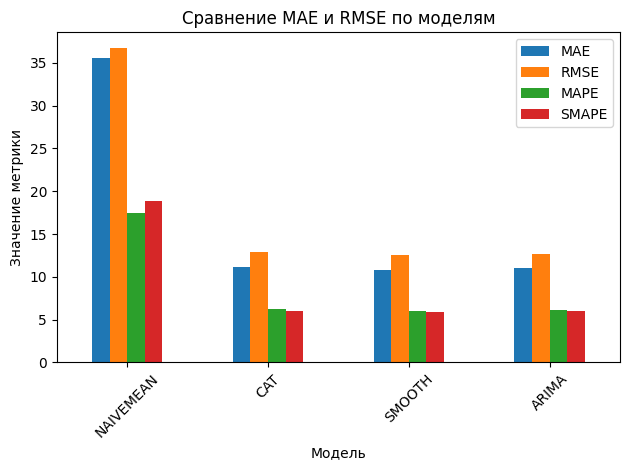


Результаты выполнения: {'naivemean': 'Успешно', 'cat': 'Успешно', 'smooth': 'Успешно', 'arima': 'Успешно'}


In [ ]:
# Простой цикл для сравнения всех моделей
import pandas as pd
import matplotlib.pyplot as plt

models = ['naivemean', 'cat', 'smooth', 'arima']
results = {}
metrics_data = []

print("="*50)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*50)

# Просто вызываем все модели по очереди
for model in models:
    print(f"\n--- МОДЕЛЬ: {model.upper()} ---")
    try:
        # Вызываем функцию и получаем результаты
        fold_results = built_predictions(model)

        # Вычисляем средние метрики
        avg_mae = sum([fold['MAE'] for fold in fold_results]) / len(fold_results)
        avg_rmse = sum([fold['RMSE'] for fold in fold_results]) / len(fold_results)
        avg_mape = sum([fold['MAPE'] for fold in fold_results]) / len(fold_results)
        avg_smape = sum([fold['SMAPE'] for fold in fold_results]) / len(fold_results)

        # Сохраняем средние метрики
        metrics_data.append({
            'Модель': model.upper(),
            'MAE': round(avg_mae, 2),
            'RMSE': round(avg_rmse, 2),
            'MAPE': round(avg_mape, 2),
            'SMAPE': round(avg_smape, 2)
        })

        results[model] = "Успешно"
    except Exception as e:
        print(f"Ошибка: {e}")
        results[model] = "Ошибка"

# Создаем таблицу сравнения
if metrics_data:
    df_results = pd.DataFrame(metrics_data)
    print("\n" + "="*60)
    print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК")
    print("="*60)
    print(df_results.to_string(index=False))

    # Простая визуализация
    plt.figure(figsize=(12, 6))
    df_results.set_index('Модель')[['MAE', 'RMSE', 'MAPE', 'SMAPE']].plot(kind='bar')
    plt.title('Сравнение MAE и RMSE по моделям')
    plt.ylabel('Значение метрики')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print(f"\nРезультаты выполнения: {results}")


def get_predictions_for_visualization():
    """Получает предсказания на 20 дней для всех моделей"""

    # Список моделей
    models = {
        'NaiveMean': NaiveMean(),
        'AutoARIMA': AutoARIMA(start_p=1, start_q=1, max_p=3, max_q=3, max_d=2, stepwise=True),
        'ExpSmooth': ExponentialSmoothing(seasonal_periods=None, seasonal=None, damped=False),
        'CatBoost': CatBoostModel(lags=5, iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=False)
    }

    predictions = {}

    print("Обучение моделей и получение предсказаний...")

    for name, model in models.items():
        try:
            print(f"Обучаем {name}...")
            model.fit(train_data)
            pred = model.predict(20)  # 20 дней вперед
            predictions[name] = pred
            print(f"✓ {name} готов")
        except Exception as e:
            print(f"✗ Ошибка в {name}: {e}")
            predictions[name] = None

    return train_data, predictions

def visualize_predictions(train_data, predictions):
    """Визуализирует предсказания всех моделей"""

    # Получаем последние 30 дней для отображения
    last_30_days = train_data[-30:]

    # Создаем график
    plt.figure(figsize=(15, 10))

    # Отображаем исторические данные
    plt.plot(range(len(last_30_days)), last_30_days.values().flatten(),
             label='Исторические данные', color='black', linewidth=2)

    # Отображаем предсказания
    colors = ['red', 'blue', 'green', 'orange']
    for i, (name, pred) in enumerate(predictions.items()):
        if pred is not None:
            plt.plot(range(len(last_30_days), len(last_30_days) + 20),
                     pred.values().flatten(),
                     label=f'{name}', color=colors[i], linewidth=2, linestyle='--')

    plt.axvline(x=len(last_30_days)-1, color='gray', linestyle=':', alpha=0.7, label='Начало предсказания')
    plt.title('Предсказания на 20 дней - Все модели')
    plt.xlabel('Дни')
    plt.ylabel('Цена акции')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Получаем данные и предсказания
    train_data, predictions = get_predictions_for_visualization()

    # Визуализируем результаты
    visualize_predictions(train_data, predictions)





In [ ]:
def get_predictions_for_visualization():
    """Получает предсказания на X дней для всех классических моделей"""

    # Загружаем данные
    df = pd.read_csv(filename, parse_dates=True)
    series = TimeSeries.from_dataframe(df, time_col='begin', value_cols='close', freq='d')

    # Подготавливаем данные (заменяем NaN)
    values = series.values().flatten()
    times = series.time_index
    freq = series.freq

    values_filled = pd.Series(values).fillna(method='ffill').values
    if np.isnan(values_filled[0]):
        values_filled = pd.Series(values_filled).fillna(method='bfill').values

    data = TimeSeries.from_times_and_values(times, values_filled, freq=freq)

    # Берем последние 100 дней для обучения
    train_data = data[-100:]

    # Список моделей
    models = {
        'NaiveMean': NaiveMean(),
        'AutoARIMA': AutoARIMA(start_p=1, start_q=1, max_p=3, max_q=3, max_d=2, stepwise=True),
        'ExpSmooth': ExponentialSmoothing(seasonal_periods=None, seasonal=None, damped=False),
        'CatBoost': CatBoostModel(lags=5, iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=False)
    }

    predictions = {}

    print("Обучение моделей и получение предсказаний...")

    for name, model in models.items():
        try:
            print(f"Обучаем {name}...")
            model.fit(train_data)
            pred = model.predict(30)  # X дней вперед
            predictions[name] = pred
            print(f"✓ {name} готов")
        except Exception as e:
            print(f"✗ Ошибка в {name}: {e}")
            predictions[name] = None

    return train_data, predictions

def visualize_predictions(train_data, predictions):
    """Визуализирует предсказания всех моделей"""

    # Получаем последние Х дней для отображения
    last_days = train_data[-100:]

    # Создаем график
    plt.figure(figsize=(15, 10))

    # Отображаем исторические данные
    plt.plot(range(len(last_days)), last_days.values().flatten(),
             label='Исторические данные', color='black', linewidth=2)

    # Отображаем предсказания
    colors = ['red', 'blue', 'green', 'orange']
    for i, (name, pred) in enumerate(predictions.items()):
        if pred is not None:
            plt.plot(range(len(last_days), len(last_days) + 30),
                     pred.values().flatten(),
                     label=f'{name}', color=colors[i], linewidth=2, linestyle='--')

    plt.axvline(x=len(last_days)-1, color='gray', linestyle=':', alpha=0.7, label='Начало предсказания')
    plt.title('Прогноз цен акций на 30 дней. Классические модели')
    plt.xlabel('Дни')
    plt.ylabel('Цена акции')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

# Пример использования:
# train_data, predictions = get_predictions_for_visualization()
# visualize_predictions(train_data, predictions)

Обучение моделей и получение предсказаний...
Обучаем NaiveMean...
✓ NaiveMean готов
Обучаем AutoARIMA...
✓ AutoARIMA готов
Обучаем ExpSmooth...
✓ ExpSmooth готов
Обучаем CatBoost...
✓ CatBoost готов


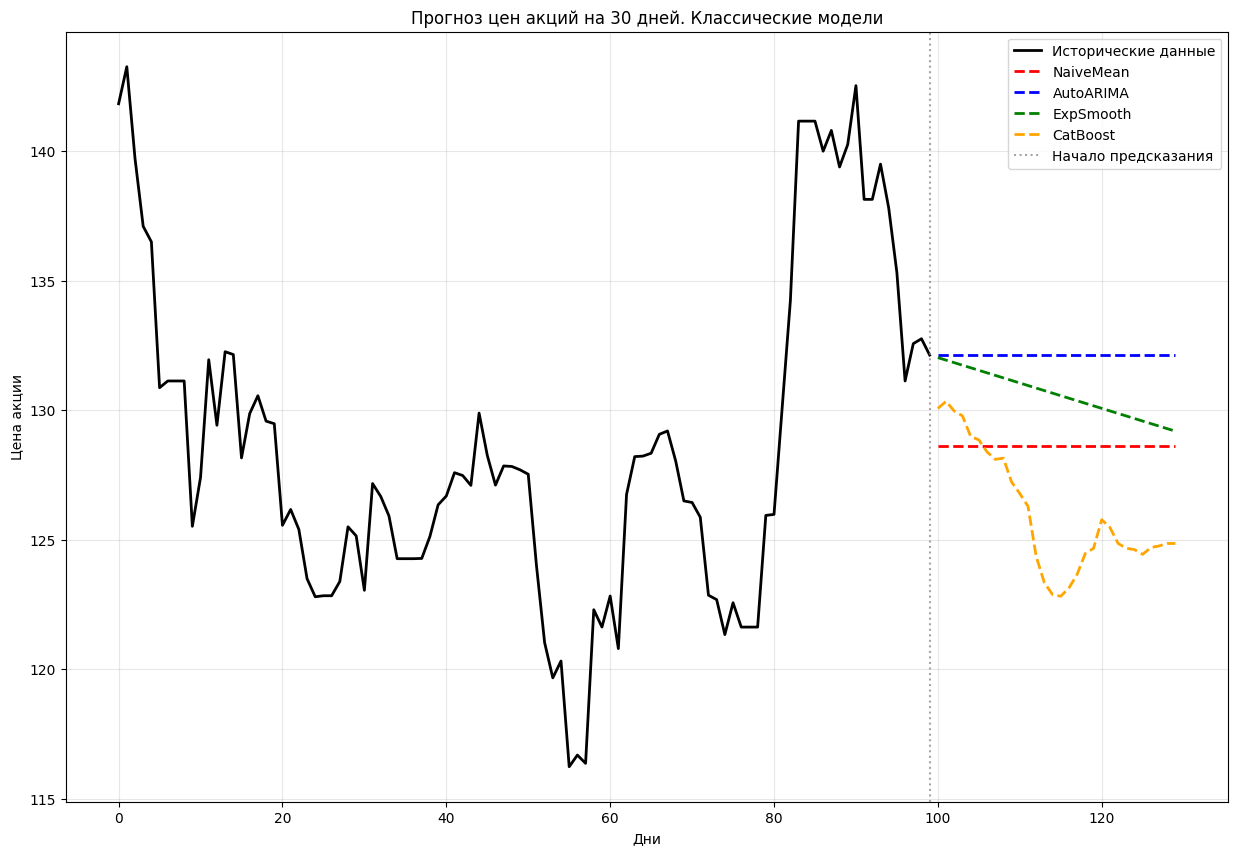

In [ ]:
 # Получаем данные и предсказания
train_data, predictions = get_predictions_for_visualization()

# Визуализируем результаты
visualize_predictions(train_data, predictions)


# 2.1 RNN (LTSM)

Создадим и обучим RNN-модель на основе LTSM, используя только реальные данные. Для этого будем использовать библиотеку Tensorflow

In [ ]:
#импортируем библиотеки и методы для работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Загружаем данные акций Газпрома из CSV файла
print("Загрузка данных...")
df = pd.read_csv(filename, parse_dates=['begin'])  # Парсим даты из столбца 'begin'
print(f"Загружено {len(df)} записей")

# Подготавливаем данные для обучения LSTM модели
def prepare_data(df, target_col='close', sequence_length=60):
    """
    Подготовка данных для LSTM модели
    Args:
        df: DataFrame с данными акций
        target_col: столбец с целевой переменной (цена закрытия)
        sequence_length: длина последовательности для предсказания
    Returns:
        X: входные последовательности
        y: целевые значения
        scaler: нормализатор для обратного преобразования
    """
    # Используем только цену закрытия как целевую переменную
    data = df[target_col].values.reshape(-1, 1)

    # Нормализация данных в диапазон [0, 1] для лучшей сходимости
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Создание последовательностей для обучения LSTM
    # Каждая последовательность содержит sequence_length предыдущих значений
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i, 0])  # Входная последовательность
        y.append(data_scaled[i, 0])  # Целевое значение (следующий день)

    # Преобразуем в numpy массивы
    X, y = np.array(X), np.array(y)
    # Изменяем форму для LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y, scaler

Загрузка данных...
Загружено 2853 записей


In [ ]:
# Параметры модели для обучения
sequence_length = 30  # 30 дней для предсказания
test_size = 0.2  # 20% данных для тестирования модели

# Подготавливаем данные для обучения
print("Подготовка данных...")
X, y, scaler = prepare_data(df, sequence_length=sequence_length)

# Разделение данных на обучающую и тестовую выборки
# Используем временное разделение (не случайное) для временных рядов
split_index = int(len(X) * (1 - test_size))
X_train, X_test = X[:split_index], X[split_index:]  # Обучающая и тестовая выборки
y_train, y_test = y[:split_index], y[split_index:]  # Целевые значения

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Подготовка данных...
Обучающая выборка: (2258, 30, 1)
Тестовая выборка: (565, 30, 1)


In [ ]:
# Создание архитектуры LSTM модели
def create_lstm_model(sequence_length, units=50, dropout=0.2):
    """
    Создание LSTM модели для прогнозирования временных рядов
    Args:
        sequence_length: длина входной последовательности
        units: количество нейронов в LSTM слое
        dropout: коэффициент dropout для предотвращения переобучения
    Returns:
        model: скомпилированная Keras модель
    """
    model = Sequential([
        # LSTM слой с указанным количеством нейронов
        # return_sequences=False - последний LSTM слой не возвращает последовательность
        LSTM(units=units, return_sequences=False, input_shape=(sequence_length, 1)),
        # Dropout слой для регуляризации и предотвращения переобучения
        Dropout(dropout),
        # Выходной слой с одним нейроном для предсказания цены
        Dense(units=1)
    ])

    # Компилируем модель с оптимизатором Adam и функцией потерь MSE
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [ ]:
# Создаем модель для быстрого обучения
model = create_lstm_model(sequence_length, units=30, dropout=0.1)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871 (15.12 KB)

 Trainable params: 3,871 (15.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Настройка callbacks для контроля процесса обучения
early_stopping = EarlyStopping(
    monitor='val_loss',  # Отслеживаем валидационную ошибку
    patience=10,  # Останавливаем обучение, если ошибка не улучшается 10 эпох
    restore_best_weights=True  # Восстанавливаем лучшие веса
)


In [ ]:
# Обучение LSTM модели на подготовленных данных

history = model.fit(
    X_train, y_train,  # Обучающие данные
    epochs=100,  # Максимальное количество эпох
    batch_size=32,  # Размер батча для обучения
    validation_split=0.2,  # 20% обучающих данных для валидации
    callbacks=[early_stopping],  # Используем раннюю остановку
    verbose=1  # Подробный вывод процесса обучения
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0491 - val_loss: 0.0065
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0104
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.4109e-04 - val_loss: 0.0041
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.7655e-04 - val_loss: 0.0044
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.3579e-04 - val_loss: 0.0035
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5602e-04 - val_loss: 0.0046
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.7468e-04 - val_loss: 0.0033
Epoch 12/100
57/57 ━━━━━━━━━━━━━

In [ ]:
# Получение предсказаний модели на обучающей и тестовой выборках

train_predictions = model.predict(X_train)  # Предсказания на обучающей выборке
test_predictions = model.predict(X_test)    # Предсказания на тестовой выборке

# Обратная нормализация предсказаний и реальных значений
# Преобразуем нормализованные значения обратно в исходные цены
train_predictions = scaler.inverse_transform(train_predictions)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Расчет метрик качества модели
def calculate_metrics(y_true, y_pred):
    """
    Расчет различных метрик качества для оценки производительности модели
    Args:
        y_true: реальные значения
        y_pred: предсказанные значения
    Returns:
        mae: средняя абсолютная ошибка
        rmse: корень из средней квадратичной ошибки
        mape: средняя абсолютная процентная ошибка
        smape: симметричная средняя абсолютная процентная ошибка
    """
    # Средняя абсолютная ошибка (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    # Корень из средней квадратичной ошибки (Root Mean Square Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Средняя абсолютная процентная ошибка (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Симметричная средняя абсолютная процентная ошибка (Symmetric MAPE)
    # Более стабильная метрика, чем MAPE
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    return mae, rmse, mape, smape

In [ ]:
# Расчет и вывод метрик качества для тестовой выборки
mae_test, rmse_test, mape_test, smape_test = calculate_metrics(y_test_inv, test_predictions)

print("\n=== РЕЗУЛЬТАТЫ LSTM МОДЕЛИ ===")
print(f"MAE: {mae_test:.2f}")      # Средняя абсолютная ошибка
print(f"RMSE: {rmse_test:.2f}")    # Корень из средней квадратичной ошибки
print(f"MAPE: {mape_test:.2f}%")   # Средняя абсолютная процентная ошибка
print(f"SMAPE: {smape_test:.2f}%") # Симметричная средняя абсолютная процентная ошибка


=== РЕЗУЛЬТАТЫ LSTM МОДЕЛИ ===
MAE: 2.08
RMSE: 3.02
MAPE: 1.49%
SMAPE: 1.49%


In [ ]:
# Визуализация результатов обучения и предсказаний модели
def plot_results(history, y_test_inv, test_predictions, y_train_inv, train_predictions, df, sequence_length):
    """
    Создание графиков для анализа результатов модели
    Args:
        history: история обучения модели
        y_test_inv: реальные значения тестовой выборки
        test_predictions: предсказания на тестовой выборке
        y_train_inv: реальные значения обучающей выборки
        train_predictions: предсказания на обучающей выборке
        df: исходный DataFrame с датами
        sequence_length: длина последовательности
    """
    fig = plt.figure(figsize=(18, 10))

    # График процесса обучения (вдвое длиннее, сверху)
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(history.history['loss'], label='Обучающая ошибка')
    ax1.plot(history.history['val_loss'], label='Валидационная ошибка')
    ax1.set_title('График обучения модели')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Ошибка (MSE)')
    ax1.legend()
    ax1.grid(True)

    # Получаем соответствующие даты для тестовой и обучающей выборок
    test_dates = df['begin'].iloc[sequence_length + len(y_train_inv):sequence_length + len(y_train_inv) + len(y_test_inv)].values
    train_dates = df['begin'].iloc[sequence_length:sequence_length + len(y_train_inv)].values

    # Графики предсказаний (снизу, рядом друг с другом)
    # Предсказания на тестовой выборке
    ax2 = plt.subplot(2, 2, 3)
    ax2.plot(test_dates, y_test_inv, label='Фактические значения', color='blue')
    ax2.plot(test_dates, test_predictions, label='Предсказания', color='red', linestyle='--')
    ax2.set_title('Предсказания на тестовой выборке')
    ax2.set_xlabel('Дата')
    ax2.set_ylabel('Цена акции (руб.)')
    ax2.legend()
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)  # Поворот подписей дат для читаемости

    # Предсказания на обучающей выборке
    ax3 = plt.subplot(2, 2, 4)
    ax3.plot(train_dates, y_train_inv, label='Фактические значения', color='blue')
    ax3.plot(train_dates, train_predictions, label='Предсказания', color='red', linestyle='--')
    ax3.set_title('Предсказания на обучающей выборке')
    ax3.set_xlabel('Дата')
    ax3.set_ylabel('Цена акции (руб.)')
    ax3.legend()
    ax3.grid(True)
    ax3.tick_params(axis='x', rotation=45)  # Поворот подписей дат для читаемости

    plt.tight_layout()
    plt.show()

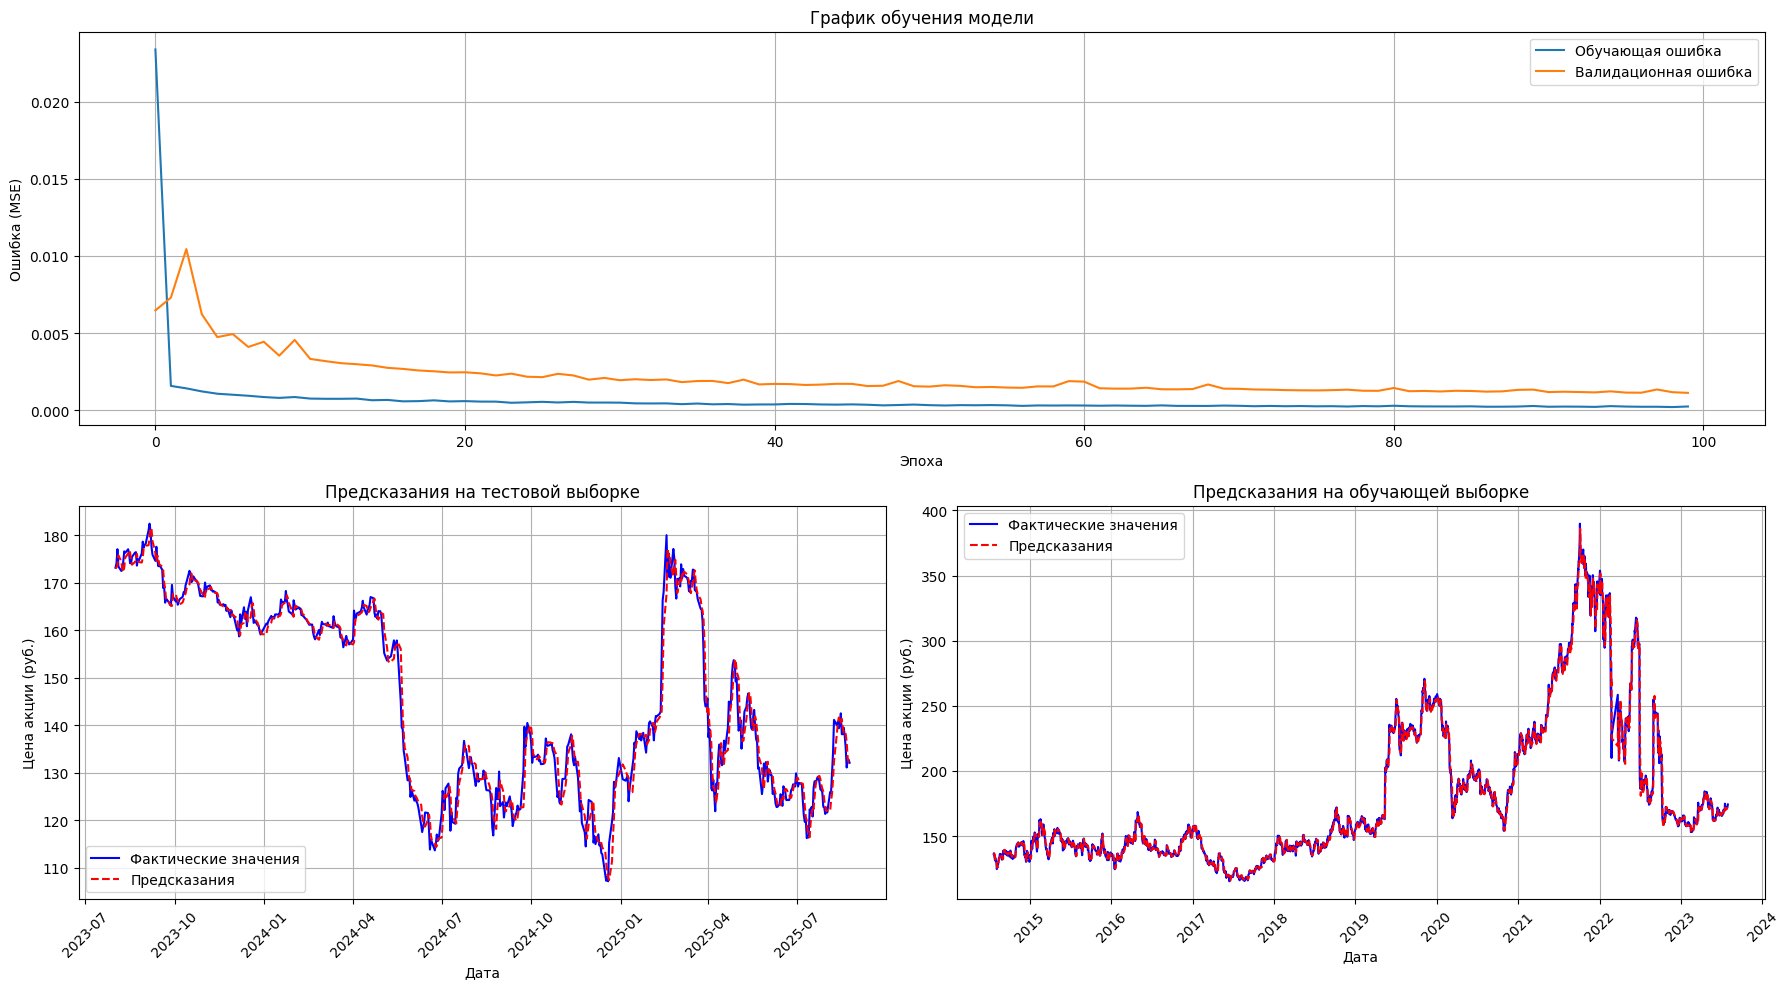

In [ ]:
# Отображение графиков результатов обучения и предсказаний
plot_results(history, y_test_inv, test_predictions, y_train_inv, train_predictions, df, sequence_length)

In [ ]:

# Функция для прогнозирования цен на будущие дни
def predict_future_days(model, last_sequence, scaler, days_ahead):
    """
    Прогнозирование цен акций на указанное количество дней вперед
    Args:
        model: обученная LSTM модель
        last_sequence: последняя известная последовательность цен
        scaler: нормализатор для обратного преобразования
        days_ahead: количество дней для прогнозирования
    Returns:
        future_predictions: массив прогнозируемых цен
    """
    future_predictions = []
    current_sequence = last_sequence.copy()  # Копируем последовательность для итеративного обновления

    for _ in range(days_ahead):
        # Получаем предсказание для следующего дня
        next_pred = model.predict(current_sequence.reshape(1, sequence_length, 1))
        future_predictions.append(next_pred[0, 0])

        # Обновляем последовательность: сдвигаем влево и добавляем новое предсказание
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    # Обратная нормализация прогнозируемых значений
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

In [ ]:
# Получаем последнюю последовательность из тестовой выборки для прогнозирования
last_sequence = X_test[-1].flatten()
future_predictions = predict_future_days(model, last_sequence, scaler, 30)

# Вывод прогнозируемых цен на 20 дней
print("\n=== ПРОГНОЗ НА 20 ДНЕЙ ===")
for i, pred in enumerate(future_predictions, 1):
    print(f"День {i}: {pred[0]:.2f}")

# Визуализация прогноза цен акций на будущие дни
plt.figure(figsize=(12, 6))

# Исторические данные (последние 100 дней для контекста)
historical_dates = df['begin'].iloc[-100:].values
historical_prices = df['close'].iloc[-100:].values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

<Figure size 1200x600 with 0 Axes>

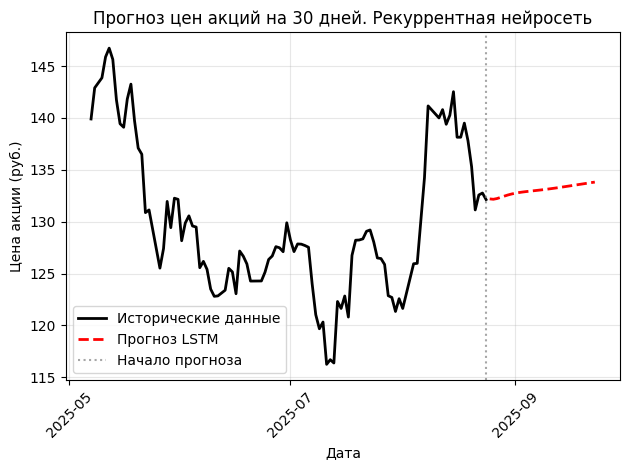

In [ ]:
# Отображаем исторические данные сплошной линией
plt.plot(historical_dates, historical_prices, label='Исторические данные', color='black', linewidth=2)

# Создаем даты для прогноза (начиная со следующего дня после последней исторической даты)
future_dates = pd.date_range(start=historical_dates[-1], periods=31)[1:]
# Отображаем прогноз пунктирной линией
plt.plot(future_dates, future_predictions, label='Прогноз LSTM', color='red', linestyle='--', linewidth=2)

# Вертикальная линия, показывающая начало прогноза
plt.axvline(x=historical_dates[-1], color='gray', linestyle=':', alpha=0.7, label='Начало прогноза')
plt.title('Прогноз цен акций на 30 дней. Рекуррентная нейросеть')
plt.xlabel('Дата')
plt.ylabel('Цена акции (руб.)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Поворот подписей дат для лучшей читаемости

# Форматирование оси дат для более понятного отображения
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=2))  # Отметки каждые 2 месяца
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))  # Формат ГГГГ-ММ

plt.tight_layout()
plt.show()

